# Monte Carlo simulation of Dynamic Risk Budgeting between PSP and GHP

We've looked at the fundamental problem of how much to allocate in the safe asset vs the performance seeking asset, and we investigated static and glidepath based techniques. Now we'll look at modern dynamic techniques that are inspired by CPPI to ensure that the account value reaches a certain target minimum floor, but also maintains exposure to the upside through a dynamic risk budget

In [1]:
import numpy as np
import pandas as pd
import risk_kit as rk
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

Let's start by building 500 scenarios for interest rates, an duration matched bond portfolio (proxied by a zero coupon bond) and a stock portfolio.

In [3]:
n_scenarios =  5000
rates, zc_prices = rk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma=0.02)
price_eq = rk.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = rk.bt_mix(rets_eq, rets_zc, allocator=rk.fixedmix_allocator, w1=0.7)
pd.concat([rk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           rk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           rk.terminal_stats(rets_7030b, name="70/30", floor=0.75)],
          axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.98,1.76
std,0.00,0.99,0.60
p_breach,NaN,0.03,0.01
e_short,NaN,0.12,0.07
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [4]:
rets_floor75 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, floor=.75,  zc_prices=zc_prices[1:])
pd.concat([rk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           rk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           rk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           rk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,1.98,1.76,1.96
std,0.00,0.99,0.60,1.00
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.12,0.07,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [6]:
rets_floor75m1 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=1)
pd.concat([rk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           rk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           rk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           rk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           rk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1
mean,1.34,1.98,1.76,1.96,1.63
std,0.00,0.99,0.60,1.00,0.44
p_breach,NaN,0.03,0.01,NaN,NaN
e_short,NaN,0.12,0.07,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN


In [7]:
rets_floor75m5 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=5)
rets_floor75m10 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=10)
pd.concat([rk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           rk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           rk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           rk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           rk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           rk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           rk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75)
          ],
          axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10
mean,1.3433,1.9792,1.7629,1.9556,1.6260,1.9660,1.9675
std,0.0000,0.9920,0.5985,0.9974,0.4377,0.9998,1.0008
p_breach,NaN,0.0342,0.0080,NaN,NaN,NaN,0.0274
e_short,NaN,0.1169,0.0718,NaN,NaN,NaN,0.0039
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


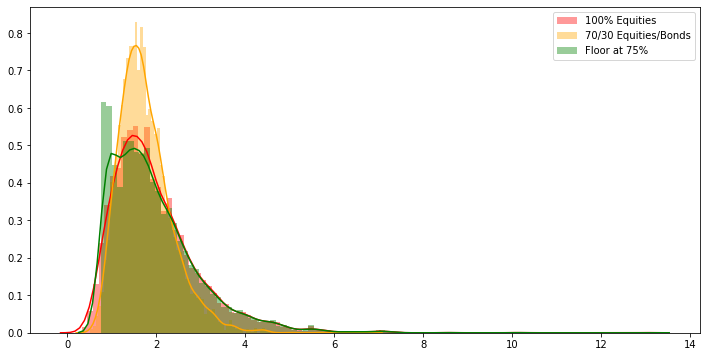

In [8]:
tv_eq = rk.terminal_values(rets_eq)
tv_zc = rk.terminal_values(rets_zc)
tv_7030b = rk.terminal_values(rets_7030b)
tv_floor75 = rk.terminal_values(rets_floor75)
tv_floor75m1 = rk.terminal_values(rets_floor75m1)
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)

plt.legend();

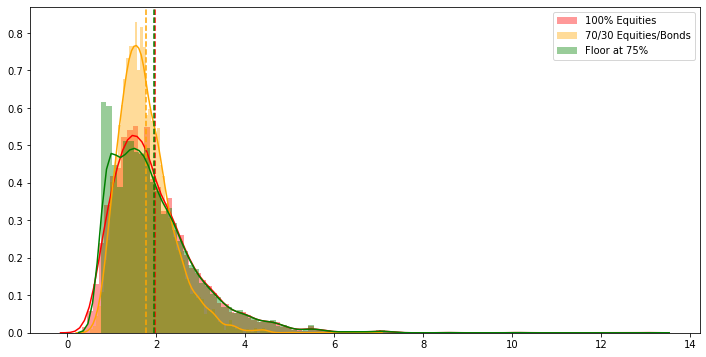

In [13]:
tv_eq = rk.terminal_values(rets_eq)
tv_zc = rk.terminal_values(rets_zc)
tv_7030b = rk.terminal_values(rets_7030b)
tv_floor75 = rk.terminal_values(rets_floor75)
tv_floor75m1 = rk.terminal_values(rets_floor75m1)
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")

plt.legend();

## Dynamic Risk Budgeting with Drawdown Constraints ##

In [10]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = rk.bt_mix(rets_eq, rets_cash, allocator=rk.drawdown_allocator, maxdd=.25)
tv_maxdd25 = rk.terminal_values(rets_maxdd25)
pd.concat([rk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           rk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           rk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           rk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           rk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           rk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           rk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75),
           rk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)           
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10,MaxDD25
mean,1.34,1.98,1.76,1.96,1.63,1.97,1.97,1.63
std,0.00,0.99,0.60,1.00,0.44,1.00,1.00,0.55
p_breach,NaN,0.03,0.01,NaN,NaN,NaN,0.03,NaN
e_short,NaN,0.12,0.07,NaN,NaN,NaN,0.00,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
rk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23378637615773892

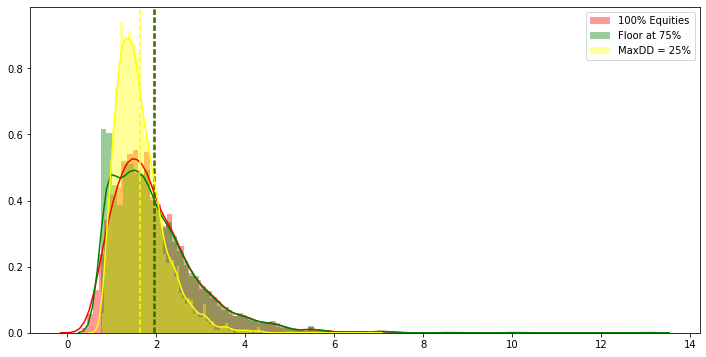

In [19]:
# Plot
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
#sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
#plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

## Backtesting Dynamic Strategies with Historical Data

Try and work with real historic data such as a the Industry Portfolios or the Total Market Index we constructed and run back tests with different parameter values. For instance:

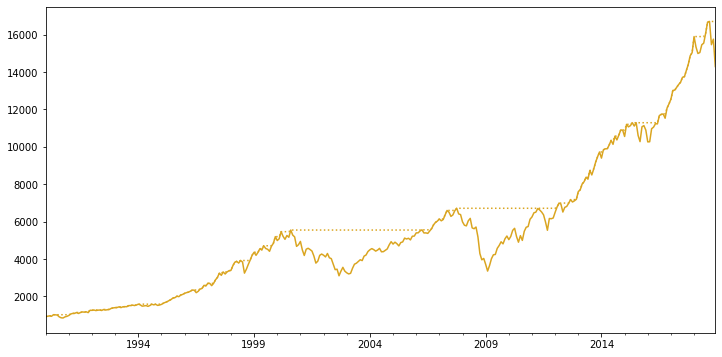

In [7]:
rets_tmi =  rk.get_total_market_index_returns()["1990":]
dd_tmi = rk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

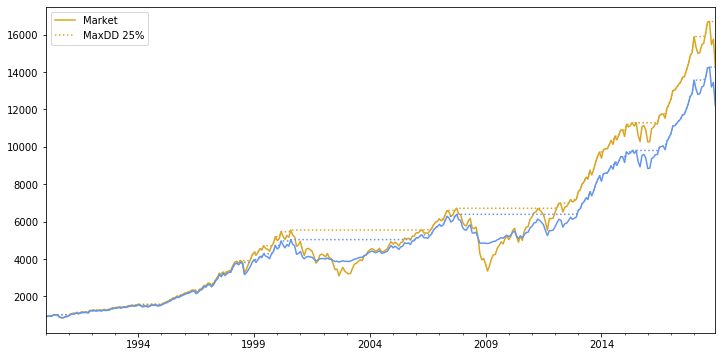

In [8]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = rk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=rk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = rk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Peaks"].plot(ax=ax, color="cornflowerblue", ls=":")

In [9]:
rk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
